In [1]:
# 步骤1: 导入所需库
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from tqdm import tqdm
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # 禁用PIL的图像尺寸限制
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun']  # 常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
import matlab.engine

In [2]:
# 步骤2: 配置路径和参数
# 设置基础路径 - 根据您的实际情况修改这些路径
BASE_DIRECTORY = r"D:\3_PRISM"
BASE_DEST_DIRECTORY = r"D:\3_PRISM"
# 选择要处理的通道
CHANNELS = ["cy5", "FAM", "DAPI", "TxRed"]
# 设置Run ID
RUN_ID = '20251015_lilab_nikon_pic_split'

In [3]:
# 步骤3: 定义辅助函数
def try_mkdir(d):
    """尝试创建目录，如果已存在则跳过"""
    try:
        os.makedirs(d)
        print(f"已创建目录: {d}")
    except FileExistsError:
        print(f"目录已存在: {d}")
    return d

def imlist_to_df(imlist):
    """将图像文件列表转换为包含元数据的DataFrame"""
    imlist_2d = [s.strip(".tif").split("-") for s in imlist]
    df = pd.DataFrame(imlist_2d, columns=["Cycle", "Tile", "Channel", "Z"])
    df = df.loc[:, ["Cycle", "Tile", "Z"]]
    for column in ["Cycle", "Tile", "Z"]:
        df[column] = df[column].apply(lambda x: int(x[1:]))
    return df

def get_stack_num(path):
    """获取Z轴堆栈层数"""
    sample = [f for f in os.listdir(path) if f.endswith(".tif") and not f.startswith(".")][0]
    prefix = sample.split("-Z")[0]
    stack_num = (max([int(f.strip(".tif").split("-Z")[1])
                 for f in os.listdir(path) if f.startswith(prefix)]) + 1)
    return stack_num

def display_zstack_sample(z_stack_names):
    """显示Z-stack样本图像"""
    if len(z_stack_names) < 3:
        return
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Z-stack样本图像', fontsize=16)
    
    # 显示第一张
    img = Image.open(z_stack_names[0])
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title(f"Z=1 (最底层)")
    axes[0].axis('off')
    
    # 显示中间层
    mid_idx = len(z_stack_names) // 2
    img = Image.open(z_stack_names[mid_idx])
    axes[1].imshow(np.array(img), cmap='gray')
    axes[1].set_title(f"Z={mid_idx+1} (中间层)")
    axes[1].axis('off')
    
    # 显示最后层
    img = Image.open(z_stack_names[-1])
    axes[2].imshow(np.array(img), cmap='gray')
    axes[2].set_title(f"Z={len(z_stack_names)} (最顶层)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def stack_cycle(in_directory, out_directory, cycle):
    """执行焦距堆栈处理"""
    print(f"\n开始处理周期: {cycle}")
    
    # 启动MATLAB引擎
    eng = matlab.engine.start_matlab()
    # 添加MATLAB库路径 - 请根据实际路径修改
    eng.addpath(r'D:\3_PRISM\Image_process\lib\preprocess')
    
    # 获取Z轴层数
    stack_num = get_stack_num(os.path.join(in_directory, cycle))
    print(f"检测到Z轴层数: {stack_num}")
    
    chn_info = {}
    total_tiles = 0
    processed_tiles = 0
    
    # 计算总图块数
    for chn in CHANNELS:
        chn_files = [f for f in os.listdir(os.path.join(in_directory, cycle)) 
                     if chn in f and f.endswith('.tif') and not f.startswith(".")]
        if chn_files:
            chn_info[chn] = imlist_to_df(chn_files)
            captured_tiles = list(chn_info[chn]["Tile"].unique())
            total_tiles += len(captured_tiles)
    
    # 处理每个通道
    for chn in CHANNELS:
        if chn in chn_info:
            cyc = chn_info[chn].loc[0, "Cycle"]
            cyc_chn_directory = os.path.join(out_directory, f"cyc_{cyc}_{chn}")
            try_mkdir(cyc_chn_directory)
            
            captured_tiles = list(chn_info[chn]["Tile"].unique())
            print(f"处理通道 {chn}, 图块数: {len(captured_tiles)}")
            
            # 使用tqdm显示进度条
            for tile in tqdm(captured_tiles, desc=f"通道 {chn}", unit="tile"):
                z_stack_names = [os.path.join(
                    in_directory, cycle, f"C{cyc:03d}-T{tile:04d}-{chn}-Z{z:03d}.tif") 
                    for z in range(stack_num)]
                
                # 显示样本图像
                if tile == captured_tiles[0]:
                    display_zstack_sample(z_stack_names)
                
                output_path = os.path.join(
                    cyc_chn_directory, f"FocalStack_{tile:03d}.tif")
                
                # 执行焦距堆栈
                try:
                    eng.fstack_write(z_stack_names, output_path, nargout=0)
                except Exception as e:
                    print(f"处理图块 T{tile:04d} 时出错: {e}")
                
                # 更新进度
                processed_tiles += 1
    
    # 关闭MATLAB引擎
    eng.quit()
    print(f"完成周期 {cycle} 的处理")

In [5]:
def process_run(run_id):
    """处理指定的Run ID"""
    print("="*50)
    print(f"开始处理Run ID: {run_id}")
    print("="*50)
    
    src_directory = os.path.join(BASE_DIRECTORY, run_id)
    dest_directory = os.path.join(
        BASE_DEST_DIRECTORY, f"{run_id}_processed", "focal_stacked"
    )
    
    print(f"源目录: {src_directory}")
    print(f"目标目录: {dest_directory}")
    
    try_mkdir(dest_directory)
    
    # 获取所有周期目录
    cycles = [f for f in os.listdir(src_directory) 
              if re.match(r"^cyc_([0-9]+)$", f) and f != "cyc_0"]
    
    if not cycles:
        print("未找到可处理的周期")
        return
    
    print("检测到以下周期:")
    for cyc in cycles:
        print(f" - {cyc}")
    
    # 处理每个周期
    for cyc in cycles:
        print(f"\n{'='*30}")
        print(f"开始处理周期: {cyc}")
        print(f"{'='*30}")
        stack_cycle(src_directory, dest_directory, cyc)
    
    print("\n所有周期处理完成!")
    print(f"结果保存在: {dest_directory}")

开始处理Run ID: 20251015_lilab_nikon_pic_split
源目录: D:\3_PRISM\20251015_lilab_nikon_pic_split
目标目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked
已创建目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked
检测到以下周期:
 - cyc_001

开始处理周期: cyc_001

开始处理周期: cyc_001
检测到Z轴层数: 10
已创建目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked\cyc_1_cy5
处理通道 cy5, 图块数: 80


通道 cy5:   0%|          | 0/80 [00:00<?, ?tile/s]

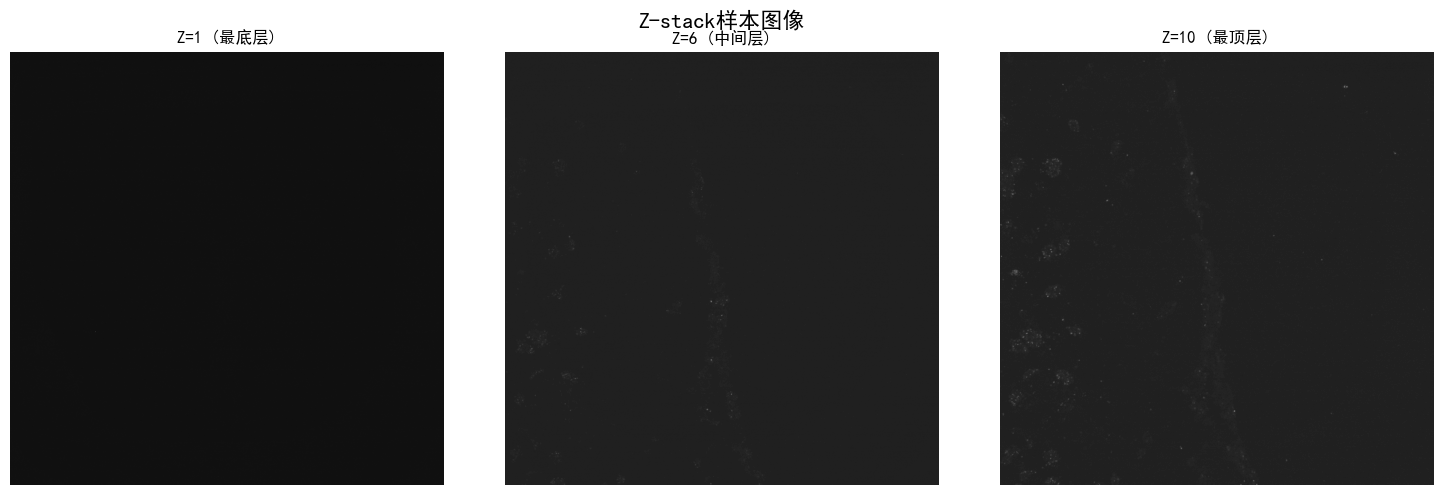

通道 cy5: 100%|██████████| 80/80 [06:57<00:00,  5.22s/tile]


已创建目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked\cyc_1_FAM
处理通道 FAM, 图块数: 80


通道 FAM:   0%|          | 0/80 [00:00<?, ?tile/s]

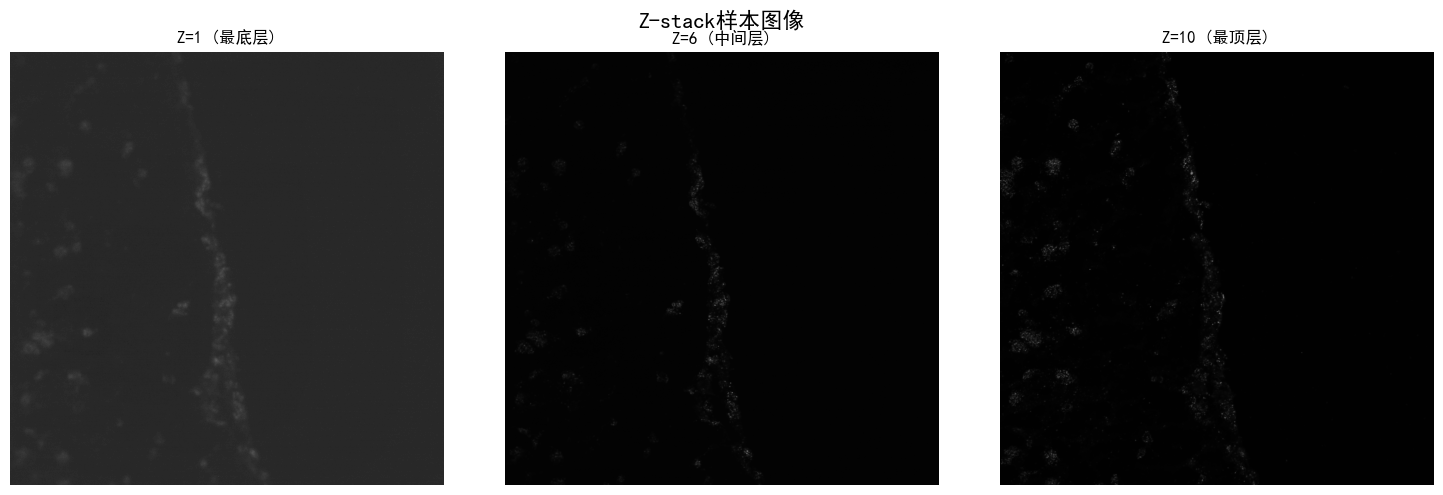

通道 FAM: 100%|██████████| 80/80 [07:05<00:00,  5.32s/tile]


已创建目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked\cyc_1_DAPI
处理通道 DAPI, 图块数: 80


通道 DAPI:   0%|          | 0/80 [00:00<?, ?tile/s]

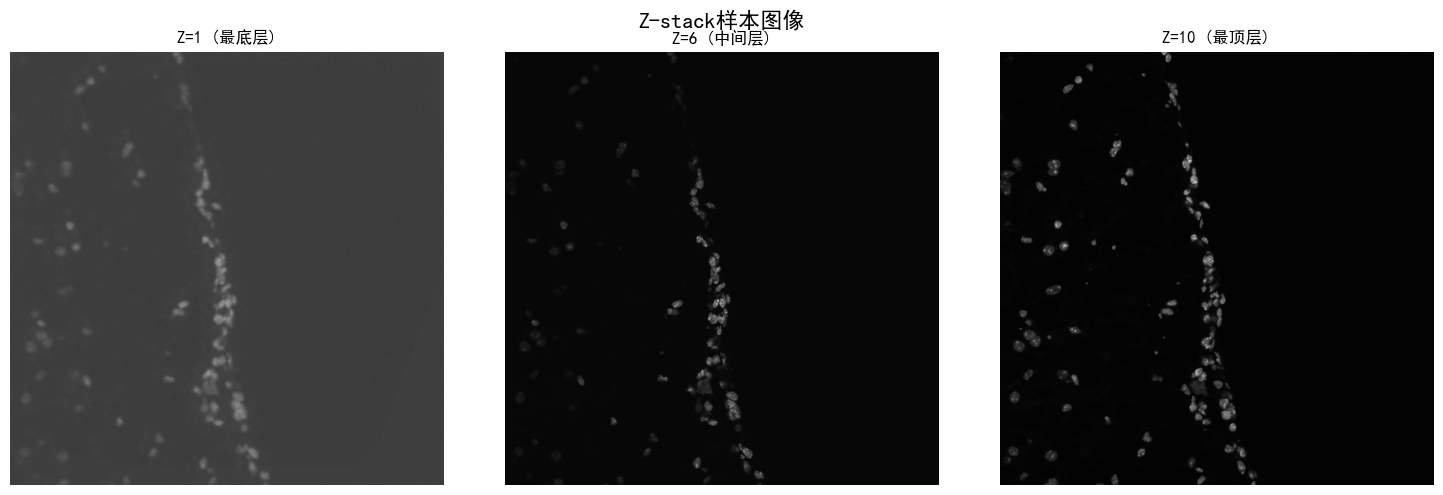

通道 DAPI: 100%|██████████| 80/80 [06:55<00:00,  5.19s/tile]


已创建目录: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked\cyc_1_TxRed
处理通道 TxRed, 图块数: 80


通道 TxRed:   0%|          | 0/80 [00:00<?, ?tile/s]

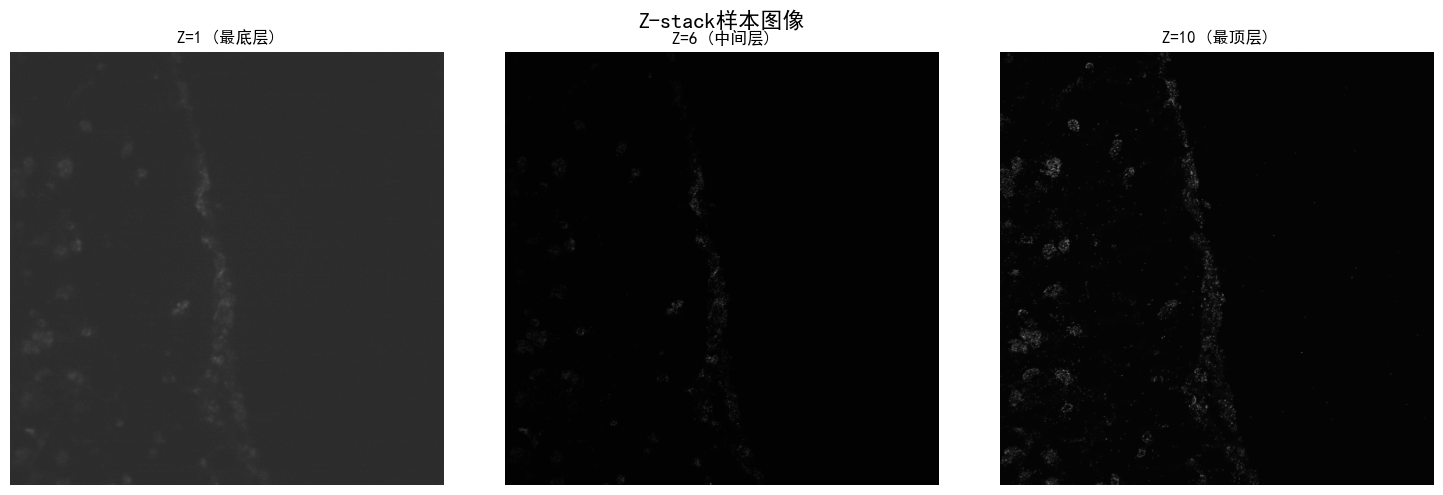

通道 TxRed: 100%|██████████| 80/80 [06:50<00:00,  5.13s/tile]

完成周期 cyc_001 的处理

所有周期处理完成!
结果保存在: D:\3_PRISM\20251015_lilab_nikon_pic_split_processed\focal_stacked


In [6]:
# 执行处理
process_run(RUN_ID)